In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
RAW_FILES = {
    'gram':      "merged_gram_reservoir.csv",
    'massor':    "merged_massor_reservoir.csv",
    'mustard':   "merged_mustard_reservoir.csv",
    'potato':    "merged_potato_reservoir.csv",
    'rabi_rice': "merged_rabi_rice_reservoir.csv",
    'wheat':     "merged_wheat_reservoir.csv"
}

In [3]:
SHORTLIST = {
    'gram':     ['Andhra Pradesh','Chhattisgarh','Gujarat','Jharkhand','Karnataka',
                 'Madhya Pradesh','Maharashtra','Rajasthan','Telangana',
                 'Uttar Pradesh','Uttarakhand','West Bengal'],
    'massor':   ['Chhattisgarh','Madhya Pradesh','Rajasthan',
                 'Uttar Pradesh','Uttarakhand','West Bengal'],
    'mustard':  ['Andhra Pradesh','Chhattisgarh','Gujarat','Jharkhand',
                 'Madhya Pradesh','Rajasthan','Uttar Pradesh',
                 'Uttarakhand','West Bengal'],
    'potato':   ['Karnataka','Uttar Pradesh','Uttarakhand','West Bengal'],
    'rabi_rice':['Andhra Pradesh','Karnataka','Telangana'],
    'wheat':    ['Gujarat','Jharkhand','Karnataka','Madhya Pradesh',
                 'Maharashtra','Rajasthan','Telangana',
                 'Uttar Pradesh','Uttarakhand','West Bengal']
}

In [4]:
RAW_DIR    = "/content/drive/MyDrive/Datas"
FILTERED_DIR  = os.path.join(RAW_DIR, "filtered_state_crop_csvs")
os.makedirs(FILTERED_DIR,  exist_ok=True)


In [5]:
for crop, fname in RAW_FILES.items():
    df = pd.read_csv(os.path.join(RAW_DIR, fname), parse_dates=['temperature_recorded_date'])
    df = df[df['temperature_recorded_date'].dt.year.between(2010, 2022)].copy()

    for state in SHORTLIST[crop]:
        df_state = df[df['state_name'] == state].copy()
        df_state.set_index('temperature_recorded_date', inplace=True)
        df_state.sort_index(inplace=True)

        out_path = os.path.join(
            FILTERED_DIR,
            f"{crop}_{state.lower().replace(' ', '')}.csv"
        )
        df_state.to_csv(out_path)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
ENGINEERED_DIR = os.path.join(RAW_DIR, "engineered_state_crop_csvs")
os.makedirs(ENGINEERED_DIR, exist_ok=True)


In [8]:
def engineer_daily_features(df):
    df = df.copy()
    # avg_temp, water_stress
    df['avg_temp']     = (df['state_temperature_max_val'] + df['state_temperature_min_val']) / 2
    df['water_stress'] = 100 - df['Live Cap FRL']

    grp = df.groupby('state_name')
    # rolling means
    df['rainfall_7d_avg'] = grp['state_rainfall_val'].rolling(7, min_periods=1) \
                                         .mean().reset_index(0, drop=True)
    df['level_7d_avg']    = grp['Level'].rolling(7, min_periods=1) \
                                       .mean().reset_index(0, drop=True)
    df['storage_7d_avg']  = grp['Current Live Storage'].rolling(7, min_periods=1) \
                                                   .mean().reset_index(0, drop=True)
    # lags
    df['rainfall_7d_lag'] = grp['state_rainfall_val'].shift(7)
    df['level_7d_lag']    = grp['Level'].shift(7)
    df['storage_7d_lag']  = grp['Current Live Storage'].shift(7)

    return df

for filepath in glob.glob(os.path.join(FILTERED_DIR, "*.csv")):
    df = pd.read_csv(filepath, index_col='temperature_recorded_date', parse_dates=True)
    df_feat = engineer_daily_features(df)

    out_file = os.path.basename(filepath)
    df_feat.to_csv(os.path.join(ENGINEERED_DIR, out_file))

In [9]:
def forecast_series(df, col, valid_dates):
    ts = df[[col]].dropna().reset_index().rename(
        columns={'temperature_recorded_date':'ds', col:'y'}
    )
    m = Prophet(daily_seasonality=True)
    m.fit(ts)

    future = pd.DataFrame({'ds': valid_dates})
    fc = m.predict(future)[['ds','yhat']]
    fc = fc.rename(columns={'ds':'date','yhat':f'forecast_{col}'})
    return fc.set_index('date')

In [10]:
results = []
for fname in sorted(os.listdir(ENGINEERED_DIR)):
    if not fname.endswith(".csv"):
        continue

    state_crop = fname.replace(".csv","")
    df = pd.read_csv(
        os.path.join(ENGINEERED_DIR, fname),
        parse_dates=['temperature_recorded_date']
    ).set_index('temperature_recorded_date')

    # require minimum data
    if df.shape[0] < 365 or df['yield'].isna().all():
        continue

    # get valid dates with a known yield
    valid = df[df['yield'].notna()].index.unique()

    # forecast Level & Storage
    fc_level   = forecast_series(df, 'Level', valid)
    fc_storage = forecast_series(df, 'Current Live Storage', valid)

    # merge forecasts
    fc = pd.concat([fc_level, fc_storage], axis=1).dropna()
    fc['level_7d_avg']   = fc['forecast_Level'].rolling(7, min_periods=1).mean()
    fc['level_7d_lag']   = fc['forecast_Level'].shift(7)
    fc['storage_7d_avg'] = fc['forecast_Current Live Storage'].rolling(7, min_periods=1).mean()
    fc['storage_7d_lag'] = fc['forecast_Current Live Storage'].shift(7)
    fc = fc.dropna()

    # align with yield
    ydf = df.loc[fc.index, ['yield']].dropna()
    X = fc.loc[ydf.index, ['level_7d_avg','level_7d_lag','storage_7d_avg','storage_7d_lag']]
    y = ydf['yield']

    # train/test split
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)

    # train RF
    rf = RandomForestRegressor(n_estimators=200)
    rf.fit(X_tr, y_tr)
    y_pred = rf.predict(X_te)

    # record metrics
    results.append({
        'state_crop': state_crop,
        'n_samples': len(y),
        'R2': r2_score(y_te, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_te, y_pred)),
        'MAE': mean_absolute_error(y_te, y_pred),
        'imp_level_avg':   rf.feature_importances_[0],
        'imp_level_lag':   rf.feature_importances_[1],
        'imp_storage_avg': rf.feature_importances_[2],
        'imp_storage_lag': rf.feature_importances_[3]
    })

DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9h5obuc/wm79xev2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9h5obuc/qfydreiq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7386', 'data', 'file=/tmp/tmpf9h5obuc/wm79xev2.json', 'init=/tmp/tmpf9h5obuc/qfydreiq.json', 'output', 'file=/tmp/tmpf9h5obuc/prophet_modeljukeiqtr/prophet_model-20250710035706.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:57:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:57:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9h5obuc/1ra9v2ai.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9h5obuc/lfgxjxmn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

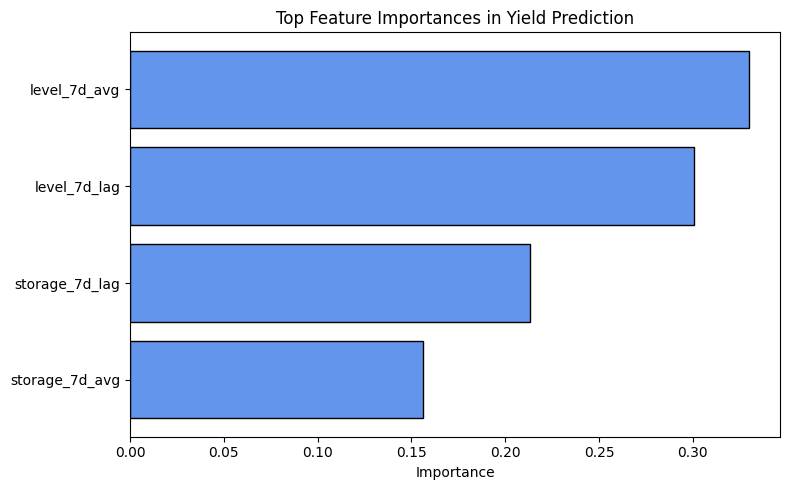

In [11]:
feature_names = X.columns.tolist()

importances = rf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

N = min(10, len(feature_names))
top_idx = sorted_idx[:N]
top_importances = importances[top_idx]
top_features = [feature_names[i] for i in top_idx]

plt.figure(figsize=(8, 5))
plt.title("Top Feature Importances in Yield Prediction")
plt.barh(range(N), top_importances, color='cornflowerblue', edgecolor='black')
plt.yticks(range(N), top_features)
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.tight_layout()



plt.show()

In [12]:
results_df = pd.DataFrame(results)
print(results_df)

                 state_crop  n_samples        R2      RMSE       MAE  \
0        gram_andhrapradesh       4741  0.707034  0.120086  0.065067   
1         gram_chhattisgarh       4741  0.865344  0.083372  0.046932   
2              gram_gujarat       4741  0.800741  0.143367  0.088913   
3            gram_jharkhand       4741  0.554919  0.120234  0.079042   
4            gram_karnataka       4741  0.449717  0.089175  0.062441   
5        gram_madhyapradesh       4741  0.749936  0.152999  0.100739   
6          gram_maharashtra       4741  0.843698  0.064504  0.038402   
7            gram_rajasthan       4741  0.632882  0.087057  0.055439   
8            gram_telangana       4741  0.648510  0.168946  0.093546   
9          gram_uttarakhand       4741  0.721074  0.015651  0.010164   
10        gram_uttarpradesh       4741  0.473966  0.237457  0.152954   
11          gram_westbengal       4741  0.770903  0.070223  0.039475   
12      massor_chhattisgarh       4741  0.961184  0.090036  0.01

In [13]:
results_df = pd.DataFrame(results).sort_values('R2', ascending=False)
print(results_df)

                 state_crop  n_samples        R2      RMSE       MAE  \
12      massor_chhattisgarh       4741  0.961184  0.090036  0.018055   
31       rabi_andhrapradesh       4741  0.868084  0.095358  0.049872   
1         gram_chhattisgarh       4741  0.865344  0.083372  0.046932   
6          gram_maharashtra       4741  0.843698  0.064504  0.038402   
33  rabi_rice_andhrapradesh       4741  0.826153  0.108246  0.055297   
26       mustard_westbengal       4741  0.824065  0.042888  0.026918   
41        wheat_maharashtra       4741  0.816720  0.104916  0.062538   
18    mustard_andhrapradesh       4741  0.803138  0.308758  0.127578   
2              gram_gujarat       4741  0.800741  0.143367  0.088913   
11          gram_westbengal       4741  0.770903  0.070223  0.039475   
46         wheat_westbengal       4741  0.762330  0.100162  0.060190   
40      wheat_madhyapradesh       4741  0.753678  0.232543  0.135002   
5        gram_madhyapradesh       4741  0.749936  0.152999  0.10

In [14]:
results_df = pd.DataFrame(results).sort_values('MAE', ascending=False)
print(results_df)

                 state_crop  n_samples        R2      RMSE       MAE  \
29      potato_uttarpradesh       4741  0.682535  2.466109  1.640971   
30        potato_westbengal       4741  0.703332  2.554869  1.528789   
27         potato_karnataka       4741  0.400682  1.652694  1.184660   
28       potato_uttarakhand       4741  0.613584  0.808343  0.489158   
43          wheat_telangana       4741  0.688952  0.393100  0.221441   
45       wheat_uttarpradesh       4741  0.421120  0.362390  0.214478   
10        gram_uttarpradesh       4741  0.473966  0.237457  0.152954   
38          wheat_jharkhand       4741  0.627382  0.215651  0.151397   
40      wheat_madhyapradesh       4741  0.753678  0.232543  0.135002   
18    mustard_andhrapradesh       4741  0.803138  0.308758  0.127578   
13     massor_madhyapradesh       4741  0.612159  0.187280  0.119522   
42          wheat_rajasthan       4741  0.524215  0.194906  0.118857   
44        wheat_uttarakhand       4741  0.680731  0.192963  0.11

In [15]:
ENGINEERED_DIR = "/content/drive/MyDrive/Datas/engineered_state_crop_csvs"
OUTPUT_YIELD_DIR = "/content/drive/MyDrive/Datas/predicted_yield"
os.makedirs(OUTPUT_YIELD_DIR, exist_ok=True)

FUTURE_DAYS = 180  # how many days ahead to forecast

# Prophet forecast for one series
def train_forecast(df, col, days_ahead):
    ts = df[[col]].dropna().reset_index().rename(columns={
        'temperature_recorded_date':'ds', col:'y'
    })
    m = Prophet(daily_seasonality=True)
    m.fit(ts)
    future = m.make_future_dataframe(periods=days_ahead)
    fc = m.predict(future)[['ds','yhat']].rename(columns={'ds':'date','yhat':f'forecast_{col}'})
    return fc.set_index('date')


In [16]:
all_metrics = []

for filepath in sorted(glob.glob(os.path.join(ENGINEERED_DIR, "*.csv"))):
    state_crop = os.path.basename(filepath).replace(".csv","")
    df = pd.read_csv(filepath, parse_dates=['temperature_recorded_date']) \
           .set_index('temperature_recorded_date')

    # require enough history
    if df.shape[0] < 365 or df['yield'].isna().all():
        continue

    # ─── 1) Forecast reservoirs ─────────────────────────────────────────────
    fc_level   = train_forecast(df, 'Level', FUTURE_DAYS)
    fc_storage = train_forecast(df, 'Current Live Storage', FUTURE_DAYS)

    # ─── 2) Merge forecasts & engineer features ────────────────────────────
    fc_df = fc_level.join(fc_storage, how='inner')
    fc_df['level_7d_avg']    = fc_df['forecast_Level'] .rolling(7, min_periods=1).mean()
    fc_df['level_7d_lag']    = fc_df['forecast_Level'] .shift(7)
    fc_df['storage_7d_avg']  = fc_df['forecast_Current Live Storage'].rolling(7, min_periods=1).mean()
    fc_df['storage_7d_lag']  = fc_df['forecast_Current Live Storage'].shift(7)
    fc_df = fc_df.dropna()

    # ─── 3) Align with historical yield for training ────────────────────────
    hist = df[['yield']].copy()
    aligned = fc_df.join(hist, how='inner').dropna(subset=['yield'])
    if aligned.shape[0] < 50:
        continue

    X = aligned[['level_7d_avg','level_7d_lag','storage_7d_avg','storage_7d_lag']]
    y = aligned['yield']

    # ─── 4) Train/test split & RF training ──────────────────────────────────
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)
    rf = RandomForestRegressor(n_estimators=200)
    rf.fit(X_tr, y_tr)

    # ─── 5) Evaluate in-sample performance ─────────────────────────────────
    y_pred = rf.predict(X_te)
    metrics = {
        'state_crop': state_crop,
        'n_samples':     len(y),
        'R2':            r2_score(y_te, y_pred),
        'RMSE':          np.sqrt(mean_squared_error(y_te, y_pred)),
        'MAE':           mean_absolute_error(y_te, y_pred)
    }
    all_metrics.append(metrics)

    # ─── 6) Predict future yields ──────────────────────────────────────────
    future_only = fc_df.loc[fc_df.index > df.index.max()]
    if not future_only.empty:
        X_prod = future_only[['level_7d_avg','level_7d_lag','storage_7d_avg','storage_7d_lag']]
        y_future = rf.predict(X_prod)
        future_only['predicted_yield'] = y_future

        # Save to CSV
        out_csv = os.path.join(OUTPUT_YIELD_DIR, f"{state_crop}_future_yield.csv")
        future_only[['predicted_yield']].to_csv(out_csv)

        # Plot forecast
        plt.figure(figsize=(10,4))
        plt.plot(future_only.index, future_only['predicted_yield'], color='green')
        plt.title(f"{state_crop} — Future Yield Forecast")
        plt.xlabel("Date"); plt.ylabel("Yield")
        plt.tight_layout()
        plt.savefig(out_csv.replace(".csv",".png"), dpi=200)
        plt.close()

DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9h5obuc/bj_rl3kw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9h5obuc/05y9cgd7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48269', 'data', 'file=/tmp/tmpf9h5obuc/bj_rl3kw.json', 'init=/tmp/tmpf9h5obuc/05y9cgd7.json', 'output', 'file=/tmp/tmpf9h5obuc/prophet_model70s6i0ko/prophet_model-20250710040713.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:07:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:07:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9h5obuc/h3o12fdn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9h5obuc/cm5ntkrv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [17]:
metrics_df = pd.DataFrame(all_metrics).sort_values('R2', ascending=False)
metrics_df.to_csv(os.path.join(OUTPUT_YIELD_DIR, "batch_model_performance.csv"), index=False)

print("Batch forecasting complete.")
print(metrics_df)

Batch forecasting complete.
                 state_crop  n_samples        R2      RMSE       MAE
12      massor_chhattisgarh       4647  0.938481  0.115782  0.021551
6          gram_maharashtra       4741  0.857508  0.060866  0.036831
31       rabi_andhrapradesh       4734  0.856239  0.100010  0.050463
33  rabi_rice_andhrapradesh       4734  0.847366  0.101941  0.051245
1         gram_chhattisgarh       4647  0.846030  0.082311  0.044669
18    mustard_andhrapradesh       4734  0.820589  0.289747  0.117743
26       mustard_westbengal       4639  0.793703  0.045718  0.029063
41        wheat_maharashtra       4741  0.788891  0.111905  0.065570
2              gram_gujarat       4733  0.785934  0.145211  0.088441
19     mustard_chhattisgarh       4647  0.782185  0.024406  0.014372
35      rabi_rice_telangana       4741  0.747875  0.138601  0.081709
36           rabi_telangana       4741  0.741729  0.134476  0.081291
46         wheat_westbengal       4639  0.738798  0.103290  0.062152
8     